In [1]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [2]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [3]:
!ls '/kaggle/input/optiver-trading-at-the-close'

example_test_files  optiver2023  public_timeseries_testing_util.py  train.csv


#### Q1: Anomalies and Cleaning, 15 pts

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
csv = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

/tmp/ipykernel_72/1025626740.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "stock_id": np.int,
/tmp/ipykernel_72/1025626740.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

In [5]:
csv.head(1)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.5,1.000026,8493.03,1.0,-3.029704,0,0_0_0


In [6]:
csv.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

For all the remaining NaN values, we will impute all the price columns as the average of the immediate previous and the immediate next values.

In [7]:
csv.sort_values(['stock_id', 'time_id'], inplace=True)

1. All the 220 null values are for 4 specific stocks (131, 101, 19, 158) for one day each. To impute them, simple bfill or ffill would not work. Instead, we need to impute for time ti on the null-values day d with the corresponding value at ti on the day d - 1 and / or d + 1 (either bfill, ffill or average of the two), for each stock.

2. Steps:

In [8]:
csv.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [9]:
# Function to fill the missing data

def HandleMissingDayData(dataframe, fillType):
    """
    Function to fill missing data with the previous and following day data at same timestamp.

    Parameters:
    fillType (boolean): -1 when just removing the rows
                        0 when forward filling using previous day record
                        1 when using mean of previous and following day record

    """
    # imbalance_size, reference_price, matched_size,bid_price, ask_price, wap,
    # far_price, near_price

    nullDataMap = {}
    nullDataFrame = dataframe[dataframe.reference_price.isnull()].copy()
    stockIds = dataframe[dataframe.reference_price.isnull()].stock_id.unique()
    # dateIds = dataframe[dataframe.reference_price.isnull()].date_id.unique()
    for stock_id in stockIds:
        # print(str(stock_id) + ": ")
        # print(nullDataFrame[nullDataFrame['stock_id'] == stock_id].date_id.unique())
        nullDataMap[stock_id] = nullDataFrame[nullDataFrame['stock_id'] == stock_id].date_id.unique()[0]

    if (fillType == 0):
        modifyingColumns = ['imbalance_size', 'matched_size', 'bid_price', 'ask_price', 'bid_size', 'ask_size', 'far_price', 'near_price', 'target', 'reference_price', 'wap']
        for stock_id in nullDataMap.keys():

            maskCurrent = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id])
            maskPrevious = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] - 1) # Doing this directly because there is no null value at date_id = 0
            # maskNext = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] + 1) # Doing this directly because there is no null value at date_id = 480
            for timestamp in range(0, 541, 10):
                for column in modifyingColumns:
                #  'far_price', 'near_price' have NaN values upto 300
                    dataframe.loc[maskCurrent & (dataframe['seconds_in_bucket'] == timestamp),
                    column] = dataframe.loc[maskPrevious & (dataframe['seconds_in_bucket'] == timestamp), column].values[0]

    elif (fillType == 1):
        modifyingColumns = ['imbalance_size', 'matched_size', 'bid_price', 'ask_price', 'bid_size', 'ask_size', 'far_price', 'near_price', 'target', 'reference_price', 'wap']
        for stock_id in nullDataMap.keys():
            print(stock_id)
            maskCurrent = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id])
            maskPrevious = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] - 1) # Doing this directly because there is no null value at date_id = 0
            maskNext = (dataframe['stock_id'] == stock_id) & (dataframe['date_id'] == nullDataMap[stock_id] + 1) # Doing this directly because there is no null value at date_id = 480

            for timestamp in range(0, 541, 10):
                for column in modifyingColumns:
                #  'far_price', 'near_price' have NaN values upto 300
                    dataframe.loc[maskCurrent & (dataframe['seconds_in_bucket'] == timestamp),
                    column] = np.mean([dataframe.loc[maskPrevious & (dataframe['seconds_in_bucket'] == timestamp), column].values[0],
                                        dataframe.loc[maskNext & (dataframe['seconds_in_bucket'] == timestamp), column].values[0]])
        if 'wap' in modifyingColumns:
            dataframe['wap'] = dataframe.apply(lambda x: (x['ask_price'] * x['bid_size'] + x['bid_price'] * x['ask_size']) / (x['bid_size'] + x['ask_size']), axis=1)
    return dataframe

In [10]:
csv = HandleMissingDayData(csv, 1)

19
101
131
158


In [11]:
row_id_set = set(csv['row_id'])
non_values = []
missing_stock_set = set()

for i in range(0, 481):
    for j in range(0, 55):
        for k in range(0, 200):
            value = f'{i}_{j*10}_{k}'
            if value in row_id_set:
                continue
            else:
                missing_stock_set.add(k)
                non_values.append(value)
print(missing_stock_set)

{99, 69, 102, 135, 199, 73, 78, 79, 150, 153, 156}


Thus, rows with null values for the target variable have been removed.

In [12]:
missing_stock_set

{69, 73, 78, 79, 99, 102, 135, 150, 153, 156, 199}

In [14]:
temp_df = csv.groupby(['stock_id', 'date_id']).agg({
    'seconds_in_bucket': 'mean',
    'imbalance_size': 'mean',
    'imbalance_buy_sell_flag': 'mean',
    'reference_price': 'prod',
    'matched_size': 'mean',
    'bid_price': 'prod',
    'bid_size': 'mean',
    'ask_price': 'prod',
    'ask_size': 'mean',
    'wap': 'mean',
    'target': 'mean',
    'time_id': 'count'  # You can change this depending on your needs
}).reset_index()

In [15]:
temp_df = temp_df[~temp_df['stock_id'].isin(missing_stock_set)]

In [16]:
temp_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
0,0,0,270.0,1.229794e+06,0.709091,0.981676,2.064913e+07,0.975384,36503.148364,0.983465,34108.372182,0.999618,-0.734535,55
1,0,1,270.0,1.175555e+06,1.000000,0.949057,9.342939e+06,0.941435,39277.045455,0.951203,25393.018909,0.999000,0.328942,55
2,0,2,270.0,1.593084e+04,0.036364,0.943330,1.306975e+07,0.940976,34400.522909,0.948465,37903.561091,0.998962,-0.326709,55
3,0,3,270.0,5.396968e+06,-1.000000,0.940381,1.414532e+07,0.937829,45016.867818,0.947246,75358.912364,0.998919,-3.225099,55
4,0,4,270.0,4.132774e+06,-1.000000,1.038598,1.882983e+07,1.035609,31768.836727,1.052155,56905.171818,1.000755,-1.614007,55


#### Q2: Pairwise Corralation Table and Explanation. 10 pts

In [17]:
correlation_matrix = csv.corr(method='pearson')

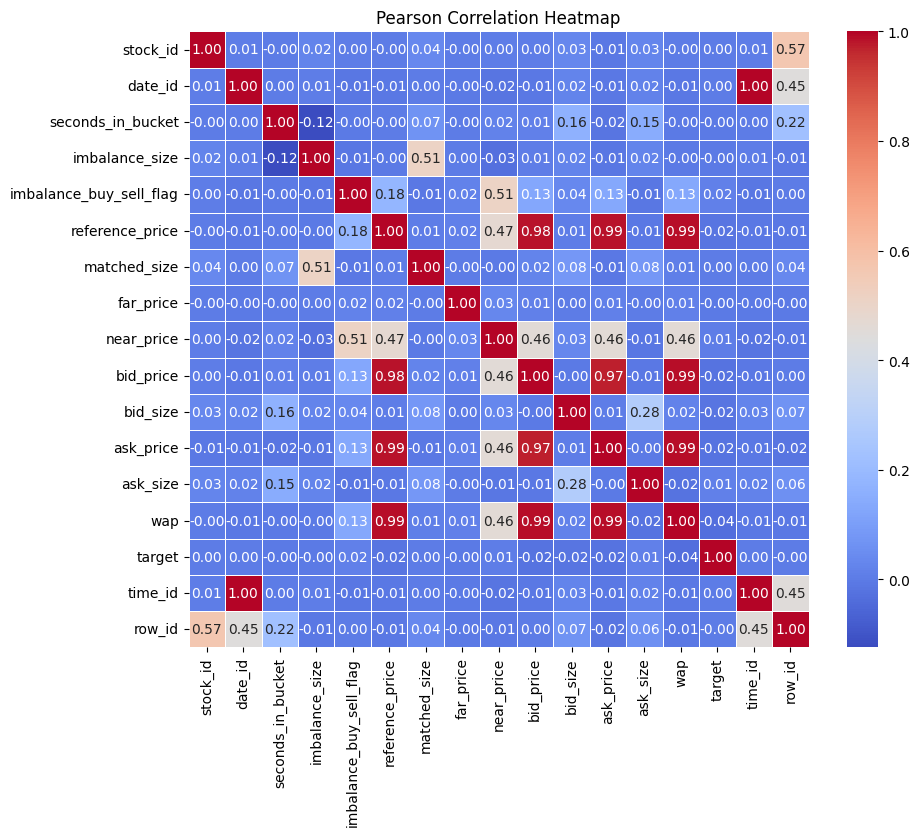

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

Reasons for high correlation values:
1. **reference_price** and **bid_price**: a high positive correlation exists between these two columns. It is positive because the bid price for a stock can only be ≥ its reference price. Further, a high absolute value of the correlation might suggest that a bidder is not likely to go much higher than what most people believe is a fair prrice for the stock (which is represented by the reference_price).
2. **wap** and **ask_price**, **wap** and **bid_price**: weighted average price is simply a linear combination of **ask_price** and **bid_price**, given by:
>
> `wap = (bid_price * ask_size + bid_size * ask_price) / (bid_size + ask_size)`
>
As a result of this linear combination, the value of "wap" exhibits a lot of correlation with bid_price and ask_price. Note that if we were using a regression model, it would probably not be wise to include all three of these features at the same time, as regression models require as low multicollinearity between different independent variables as possible so as to obtain a good result, and a high correlation often indicates high multicollinearity.

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts

In [ ]:
csv.describe()

In [ ]:
csv.head(1)

In [ ]:
average_records = csv.groupby(['stock_id', 'date_id']).agg({
    'seconds_in_bucket': 'mean',
    'imbalance_size': 'mean',
    'imbalance_buy_sell_flag': 'mean',
    'reference_price': 'mean',
    'matched_size': 'mean',
    'bid_price': 'mean',
    'bid_size': 'mean',
    'ask_price': 'mean',
    'ask_size': 'mean',
    'wap': 'mean',
    'target': 'mean',
    'time_id': 'count'  # You can change this depending on your needs
}).reset_index()

In [ ]:
average_records.shape

In [ ]:
average_records.head()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Sort the data by 'stock_id', 'date_id', and 'time_id' in ascending order
csv.sort_values(by=['stock_id', 'date_id', 'time_id'], inplace=True)

# Group data by 'stock_id' and 'date_id' and select the last record for each group
# last_records = csv.groupby(['stock_id', 'date_id']).last().reset_index()

In [ ]:
autocorrelation_results = {}

unique_stock_ids = csv['stock_id'].unique()

for stock_id in unique_stock_ids:
    autocorrelation_results[stock_id] = [[], []]
#     stock_data = last_records[last_records['stock_id'] == stock_id]
#     stock_data = last_records[last_records['stock_id'] == stock_id].copy()
    stock_data = average_records[average_records['stock_id'] == stock_id].copy()
#     max_autocorr = -1
#     optimal_lag = 0
    
    for shift in range(-10, 11):
        if shift != 0:
            temp = stock_data['target'].autocorr(lag=shift)
            autocorrelation_results[stock_id][0].append(shift)
            autocorrelation_results[stock_id][1].append(temp)
#         if temp > max_autocorr:
#             max_autocorr = temp
#             optimal_lag = shift
            
    
    # Calculate the average distance for each day
#     average_distance = stock_data.groupby('date_id')['distance'].mean()

    # Calculate autocorrelation for lags from -10 to 10
#     autocorrelation_results[stock_id] = []

#     for lag in range(-10, 11):
#         autocorr = average_distance.autocorr(lag=lag)
#         autocorrelation_results[stock_id].append((lag, autocorr))

# Perform a hypothesis test for each stock to determine statistical significance
# sig = []
# non_sig = []
# for stock_id, results in autocorrelation_results.items():
#     autocorrelation_df = pd.DataFrame(results, columns=['Lag', 'Autocorrelation'])
#     result = smf.ols('Autocorrelation ~ Lag', data=autocorrelation_df).fit()

#     # Check if the autocorrelation is statistically significant
#     p_value = result.pvalues['Lag']
# #     print(f"p value is {p_value}")
#     alpha = 0.5  # Significance level

#     if abs(p_value) < abs(alpha):
#         sig.append(stock_id)
# #         print(f"Stock {stock_id}: The autocorrelation is statistically significant (p-value < 0.05).")
#     else:
#         non_sig.append(stock_id)
#         print(f"Stock {stock_id}: The autocorrelation is not statistically significant (p-value >= 0.05).")

In [ ]:
csv = csv.sort_values(by=['stock_id', 'date_id', 'time_id'])

# Define the number of days to look back and ahead (10 in this case).
look_back_days = 10
look_ahead_days = 10

# Create an empty DataFrame to store the autocorrelation results.
autocorrelation_results = pd.DataFrame(columns=['stock_id', 'autocorrelation'])

# Group the data by 'stock_id'.
grouped = df.groupby('stock_id')

# Iterate through each group (stock_id).
for stock_id, group in grouped:
    # Calculate autocorrelation for each 'target' value in the group.
    autocorrelations = []
    for i in range(-look_back_days, look_ahead_days + 1):
        autocorrelation = group['target'].autocorr(lag=i)
        autocorrelations.append(autocorrelation)

    # Create a DataFrame for the results and append it to the main results DataFrame.
    stock_autocorr_df = pd.DataFrame({'stock_id': [stock_id] * (2 * look_back_days + 1), 'autocorrelation': autocorrelations})
    autocorrelation_results = autocorrelation_results.append(stock_autocorr_df, ignore_index=True)

# Print or save the autocorrelation results.
print(autocorrelation_results)

In [ ]:
len(autocorrelation_results.keys())

In [ ]:
print(len(sig), len(non_sig))

In [ ]:
len(csv['stock_id'].unique())

In [ ]:
csv.head()

In [ ]:
csv_stockwise = {}
unique_stocks = csv['stock_id'].unique()
for stock in unique_stocks:
    csv_stockwise[stock] = csv[csv['stock_id'] == stock]

In [ ]:
plt.figure(figsize=(11,4), dpi= 80)
pd.plotting.autocorrelation_plot(csv_stockwise[0].loc[:, 'bid_price'])

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts

In [19]:
temp_df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
dtype: int64

In [20]:
perf_df = pd.DataFrame()
temp_df["row_number"] = temp_df.groupby("date_id").cumcount() + 1
perf_df = temp_df.pivot(index='date_id', columns='row_number', values=['reference_price'])
perf_df.columns = [f'stock_{stock_id}' for stock_id in temp_df['stock_id'].unique()]
perf_df.reset_index(inplace=True)

In [21]:
perf_df.head(5)

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198
0,0,0.981676,0.980665,0.975142,0.972667,0.959123,1.066424,1.018245,0.957461,0.937763,...,1.093058,1.070061,1.164560,0.938123,1.003088,0.964803,0.970614,0.976426,0.989290,1.012147
1,1,0.949057,1.013241,1.028246,0.990507,1.083755,1.124239,1.019209,1.062784,1.002415,...,0.982872,0.979526,0.987466,1.035821,1.106003,1.228496,1.002279,0.960323,1.039529,0.997516
2,2,0.943330,0.816405,0.971594,0.993642,0.897965,0.992049,1.006411,1.047231,0.854475,...,0.977736,0.875654,0.982164,1.063471,1.034076,0.983915,0.946070,0.976866,1.054993,0.990386
3,3,0.940381,1.170528,1.051236,0.976517,1.007361,1.023666,0.900020,1.038102,1.010036,...,1.032623,1.064633,1.013655,1.033913,1.047087,1.139446,1.053194,1.017672,1.046020,0.994901
4,4,1.038598,1.072566,1.104198,1.013751,1.122115,0.948031,0.974695,1.099928,1.155052,...,0.975662,0.942585,0.974158,1.058170,1.094019,1.132269,0.930090,0.992498,1.007910,1.022006


In [22]:
for col in perf_df.columns:
    if col != 'date_id':
        perf_df[col] = perf_df[col].apply(lambda x : 1 if x > 1 else -1)

In [23]:
perf_df.head()

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_189,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198
0,0,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,1,-1,1,-1,-1,-1,-1,1
1,1,-1,1,1,-1,1,1,1,1,1,...,-1,-1,-1,1,1,1,1,-1,1,-1
2,2,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,-1,1,1,-1,-1,-1,1,-1
3,3,-1,1,1,-1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,1,-1
4,4,1,1,1,1,1,-1,-1,1,1,...,-1,-1,-1,1,1,1,-1,-1,1,1


In [24]:
columns_to_be_added = [col for col in perf_df.columns]
columns_to_be_added.remove('date_id')
perf_df['total']= perf_df[columns_to_be_added].sum(axis=1)

/tmp/ipykernel_72/2072966057.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  perf_df['total']= perf_df[columns_to_be_added].sum(axis=1)


In [25]:
perf_df.head()

,date_id,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,...,stock_190,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,total
0,0,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,1,-1,-1,-1,-1,1,-9
1,1,-1,1,1,-1,1,1,1,1,1,...,-1,-1,1,1,1,1,-1,1,-1,7
2,2,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,1,1,-1,-1,-1,1,-1,-89
3,3,-1,1,1,-1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,-1,91
4,4,1,1,1,1,1,-1,-1,1,1,...,-1,-1,1,1,1,-1,-1,1,1,49


In [26]:
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation due to catastrophic cancellation.")
up_days = []
down_days = []
alpha = 0.05
for date in perf_df['date_id'].unique():
    dist = perf_df[perf_df['date_id'] == date][columns_to_be_added].values.flatten().tolist()
    t_statistic, p_value = stats.ttest_1samp(dist, 0)
    if p_value < alpha / 2:
        if t_statistic >= 0:
            up_days.append(date)
        else:
            down_days.append(date)

In [27]:
print(f"{len(up_days)} up days")
print(f"{len(down_days)} down days")

179 up days
203 down days


## Three plots

### 1. Net stock performance vs. frequency

Text(0, 0.5, 'Frequency')

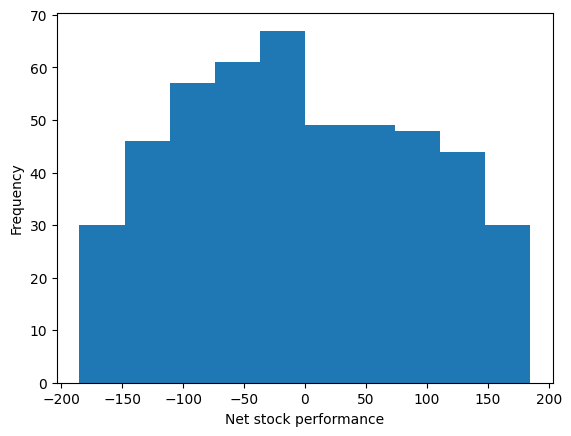

In [29]:
plt.hist(perf_df['total'])
plt.xlabel('Net stock performance')
plt.ylabel('Frequency')

This graph describes the net performance of all stocks for all days vs. frequency. The graph indicates a large volume of days experiencing stocks performing below average in a statistically significant manner. This is backed by our values of number of stocks performing well and number of stocks not performing well, as computed previously.

### 2. Overall market performance during first 100 days to identify the bad days.

<Figure size 640x480 with 0 Axes>

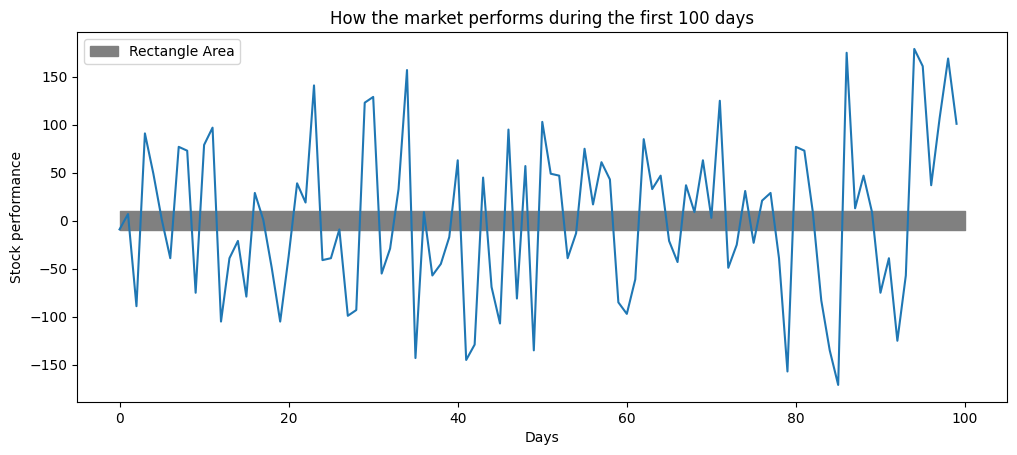

In [30]:
# stock_ids = temp_df['stock_id'].unique()[0 : 50]
days = temp_df['date_id'].unique()[0:100]
y = perf_df['total'][0:100]
plt.figure(figsize=(12, plt.gcf().get_figheight()))
plt.plot(days, y, linestyle='-')
# plt.axhline(y=0, color='r', linestyle='-')
rect_start_x = 0
rect_end_x = 100
rect_bottom = -10
rect_top = 10
plt.fill_between([rect_start_x, rect_end_x], rect_bottom, rect_top, color='gray', alpha=1, label='Rectangle Area')
plt.xlabel('Days')
plt.ylabel('Stock performance')
plt.title('How the market performs during the first 100 days')
plt.legend()
plt.show()

For the first 100 days, the days when the stock market performs the worst (i.e deep troughs) occur at approximately regular intervals of 6 to 8 days, except for when no deep trough occurs between 60 and 80. Note that these deep troughs are only the worst performances for the stock market. There are of course other days between each successive deep troughs where the stock market performs bad in a statistically significant manner, but maybe not to the extent of these regularly occurring deep troughs. Although the visual confirmation may be misleading, one can see that overall in the graph, there are more bad days than good. This sample of the first 100 days displays similar results as the entire population (i.e there are more bad days than good). To approximate statistical significance, I have considered a window of "total" in the range [-10, 10] as being just good or bad 'by chance'.

#### Q5: Best prediction model, any approaches, 25 pts

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = temp_df[]
X, y = iris.data, iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and configure the XGBoost classifier
model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)


In [ ]:
temp_df.head()

#### Q6: submit model on Kaggle, 0 pts
Public Score: \
Private Score: \
Kaggle profile link: \
Screenshot(s):
